# Applying Stereo Depth to a Driving Scenario

Use OpenCV to complete standard vision tasks.

- Understand the process of obtaining depth from a pair of stereo images and their respective projection matrices.
- Understand the advantages of cross-correlation for localization of important information in an image.






## 1. Packages


- [numpy](www.numpy.org) - For scientific computing with Python.
- [matplotlib](http://matplotlib.org) - To plot graphs in Python.
- [cv2] (https://opencv.org) - For computer vision applications in Python. 
- The `files_management` - Pre-developed functions for importing data for the assignment.







In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f
import files_management

### 1.1 Read and Display Stero Images


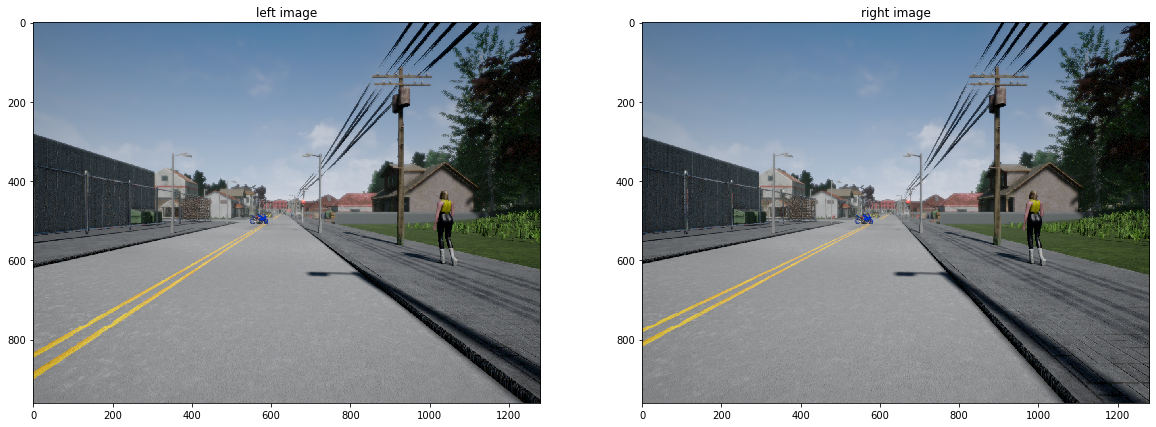

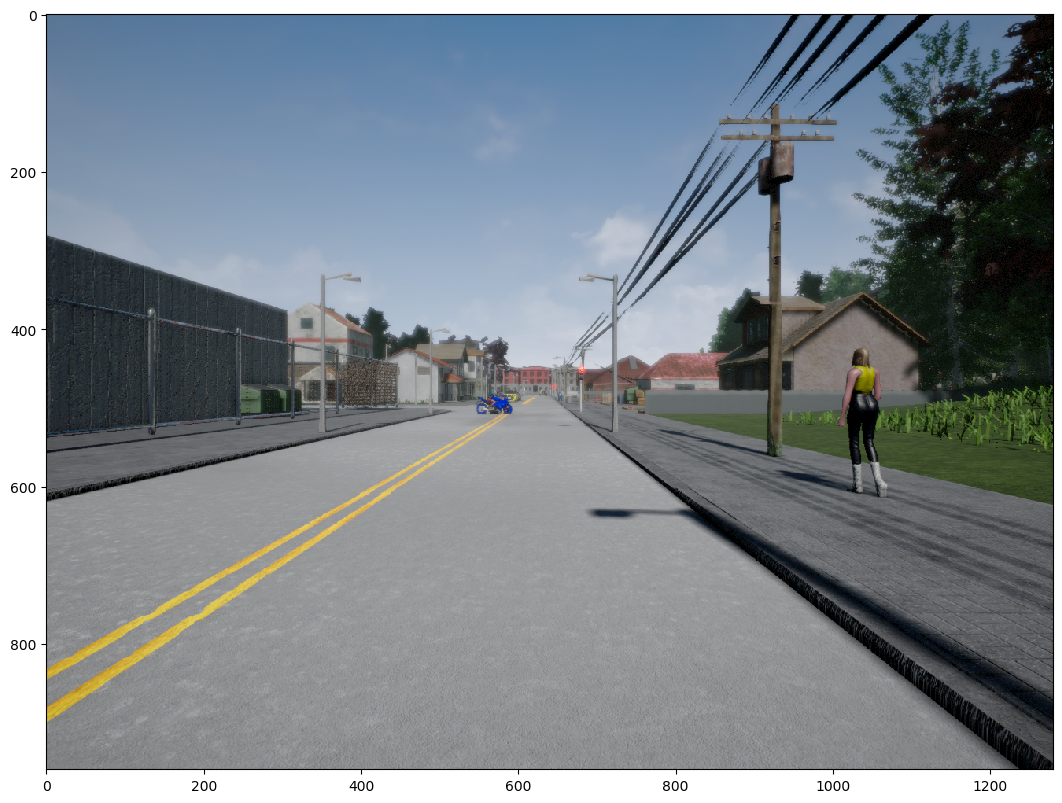

In [17]:
# Read the Stereo Pair of Images
img_left = files_management.read_left_image()
img_right = files_management.read_right_image()

# Use matplotlib to display the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right)
image_cells[1].set_title('right image')
plt.show()
# Large plot of the left image
plt.figure(figsize=(14, 1), dpi=100)
plt.imshow(img_left)

### 1.2 Read Projection Matrices


In [3]:
# Read the Calibration Matrix
p_left, p_right = files_management.get_projection_matrices()

# Display the Calibration Matrix in Integers
np.set_printoptions(suppress=True) 

print("Projection Matrix Left \n", p_left)
print("\n Projection Matrix Right \n", p_right)

Projection Matrix Left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

 Projection Matrix Right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


## 2. Estimating Depth

We can estimate the depth of a stereo scene using the following sequence of actions:

1. Determine the **disparity** between the two images.


2. Decompose the **projection matrices** into the camera intrinsic matrix $K$, and extrinsics $R$, $t$.


3. Estimate depth using what we've gathered in the two prior steps.

### 2.1 Computing the Disparity

- The `compute_left_disparity_map` function is expected to recieve a stereo pair of images and **returns a disparity map from the perspective of the left camera.**

    There are two OpenCV functions that we can use to compute a disparity map [StereoBM](https://docs.opencv.org/3.4.3/d9/dba/classcv_1_1StereoBM.html) and [StereoSGBM](https://docs.opencv.org/3.4.3/d2/d85/classcv_1_1StereoSGBM.html). 
    

- Once you've chosen the matcher to use you can call `matcher.compute(img_left, img_right)` to generate the disparity output.

**Note**: make sure you are using **GRAYSCALE** images for the `matcher.compute()` method. 

In [4]:
def compute_left_disparity_map(img_left, img_right):
    
    ### START CODE HERE ###
    
    # Parameters for the BM and SGBM functions
    
    num_disparities = 6*16 # (Max. Disp. - Min. Disp.) - The parameter should be divisbible by 16.
    block_size = 11 # Must be an ODD number >=1 usually in the range of 3 to 11.
    min_disparity = 0 # Should usually = 0, sometimes algorithms can shift images, then can be adjusted
    window_size = 6 # NO IDEA WHAT THIS IS !!!!!!!!!
    
    # Convert in to GRAYSCALE required because the method calls for it
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    
    # Stereo BM matcher
    #left_matcher_BM = cv2.StereoBM_create
    #(
    #    numDisparities = num_disparities,
    #    blockSize = block_size
    #)

    # Stereo SGBM matcher
    # P1 and P2 are the parameters that control the disparity smoothness. 
    # P2 > P1  (Always)
    # P1 = Penalty on the disparity change by +-1 between neighbour pixels.
    # P2 = Penalty on the disparity change by > 1 between neighbour pixels.
    # mode = Should be appropriately selected based on the different algorithms available 
       
    left_matcher_SGBM = cv2.StereoSGBM_create(
        minDisparity = min_disparity,
        numDisparities = num_disparities,
        blockSize = block_size,
        P1 = 8 * 3 * window_size ** 2,
        P2 = 32 * 3 * window_size ** 2,
        mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute the Left Disparity Map
    # astype is a method of an array. It takes the values of the array and produces a new array with the desire dtype. 
    # It does not act retroactively (or in-place) on the array itself, or on the function that created that array.
    
    disp_left = left_matcher_SGBM.compute(img_left, img_right).astype(np.float32)/16
    
    ### END CODE HERE ###
    
    return disp_left

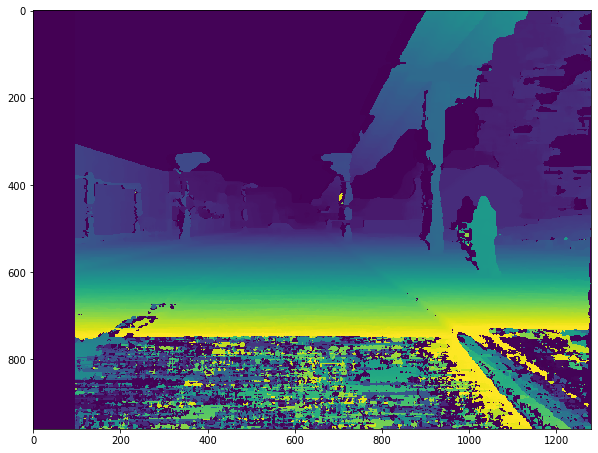

In [5]:
# Compute the disparity map using the fuction above
disp_left = compute_left_disparity_map(img_left, img_right)

# Show the LEFT disparity map
plt.figure(figsize=(10, 10))
plt.imshow(disp_left)
plt.show()

### 2.2 Decompose the Projection Matrices

1. Represent $P$ as a combination of the intrinsic parameters $K$ and the extrinsic rotation $R$ and translation $t$ as follows: 
$$ $$
$$P = K[R|t]$$
$$ $$
2. We take the inverse of $KR$, which allows us to perform **QR-decomposition** to get $R^{-1}$ and $K^{-1}$: 
$$ $$
$$(KR)^{-1} = R^{-1}K^{-1}$$
$$ $$
3. From here it would seem as though we could easily determine $K$, $R$, and $t$.


4. Unfortunately, this isn't as simple as it seems due to the **QR-decomposition isn't unique**. 


5. This results in us having to check:
    - Sign of the diagonal of the $K$ matrix

    - Adjust $R$ appropriately




6. We must also make assertions about the directions of our camera and image x, y, and z axes.




7. OpenCV provides us with a single function that does all of this. Using cv2.[decomposeProjectionMatrix()](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248). Use this function below to extract the required matrices.


**Note**: After carrying out the matrix multiplication, the **homogeneous component ($w_c != 1$ )** in general. 

Therefore, **to map back into the real plane** we must **perform the homogeneous divide or perspective divide by dividing each component by ($w_c$)**

In [6]:
def decompose_projection_matrix(p):
    
    ### START CODE HERE ###
    # Here the w_c component is the 4th element of the (t) 1x4 coloumn matrix
    # Therefore w_c = t[3]
    # Since we want the w_c = 1 we will divide the 1x4 matrix by that value which results in w_c = 1
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3]
    
    ### END CODE HERE ###
    
    return k, r, t

In [7]:
# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("K_left \n", k_left)
print("\n R_left \n", r_left)
print("\n t_left \n", t_left)
print("\n K_right \n", k_right)
print("\n R_right \n", r_right)
print("\n t_right \n", t_right)

K_left 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

 R_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

 t_left 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

 K_right 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

 R_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

 t_right 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


### 2.3 Generate the Depth Map


1. From the $K$ matrix we will obtain:
    - **Focal length ($f$) = $K[0,0]$** 
    
    
2. From the $T$ matrix we will obtain baseline which is the distance between the 2 cameras:
    - **Baseline ($b$) = $t_L[1] - t_R[1] $**
    
    
3. Now the depth map of the image: (Where: ($d$) is disparity map)

   $$Z = \frac{f b}{x_L - x_R} = \frac{f b}{d}$$ 


**Note:** Don't forget to address problematic disparities (the ones having of 0 and -1) to eliminate potential computational issues.

The function below to return a depth map of the same dimensions as the disparity map being provided.

In [8]:
def calc_depth_map(disp_left, k_left, t_left, t_right):

    ### START CODE HERE ###
    
    # Focal length from the K matrix
    f = k_left[0, 0]

    # Baseline is the distance between the cameras from the t matrices
    b = t_left[1] - t_right[1]

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.01
    disp_left[disp_left == -1] = 0.1

    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)

    # Calculate the depths 
    depth_map[:] = (f * b) / disp_left[:]
    
    ### END CODE HERE ###
    
    return depth_map

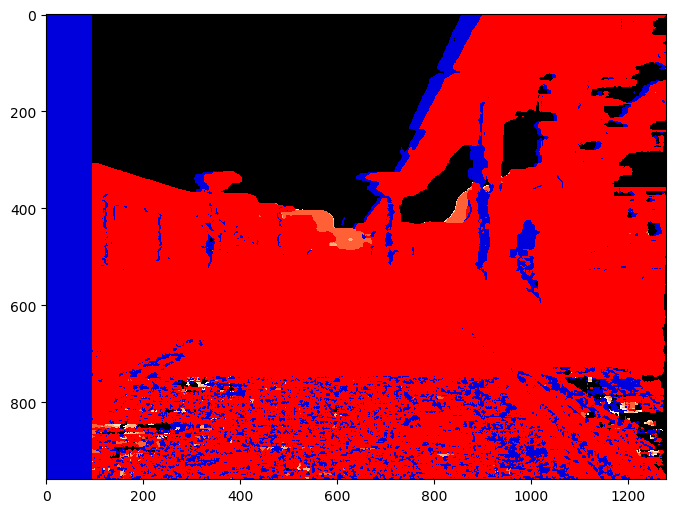

In [9]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

## 3. Finding the Distance to Collision

1. We have a map of the depths of each pixel in the scene, our system does not yet know which of these pixels are safe (like the road) or a potential obstacle (like a motorcycle). 


2. To find these objects of interest we **run an object detector that has been trained to select a rectangular section containing the object we are concerned about.**

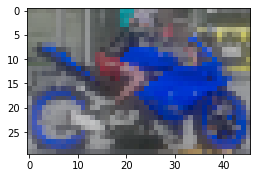

In [10]:
# Get the image of the obstacle
obstacle_image = files_management.get_obstacle_image()

# Show the obstacle image
plt.figure(figsize=(4, 4))
plt.imshow(obstacle_image)
plt.show()

### Manual Cross-Correleation


The algorithm behind cross correlation requires us to perform large numerical computations at each pixel in the image. 

   - Using the cv2.[matchTemplate()](https://docs.opencv.org/3.4.3/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be) function we can quickly and easily complete the cross correlation of the obstacle template.
      
   - From this heatmap we can use the cv2.[minMaxLoc()](https://docs.opencv.org/3.4.3/d2/de8/group__core__array.html#ga8873b86a29c5af51cafdcee82f8150a7) function to extract the position of the obstacle.


#### Locating the Obstacle 

Input:
- Image
- Image of the Obstacle


Output:
- Cross-Correlation **Heatmap**
- Location of the obstacle

In [11]:
def locate_obstacle_in_image(image, obstacle_image):
    
    ### START CODE HERE ###
    
    # Run the template matching from OpenCV
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method=cv2.TM_CCOEFF)
    
    # Locate the position of the obstacle using the minMaxLoc function from OpenCV
    _, _, _, obstacle_location = cv2.minMaxLoc(cross_corr_map)

    ### END CODE HERE ###

    return cross_corr_map, obstacle_location

 The Obstacle Location is:  (547, 479)


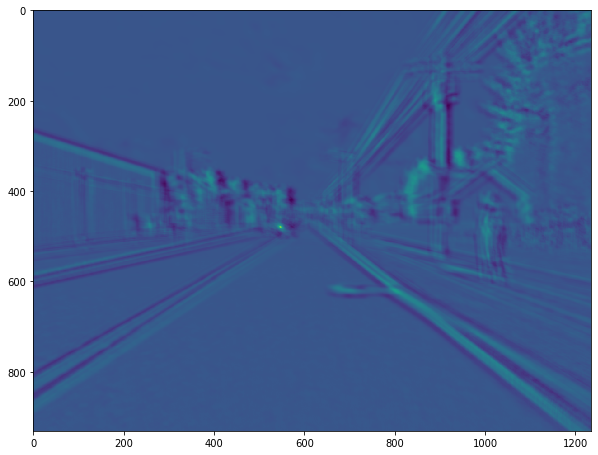

In [12]:
# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)

# Print the obstacle location
print(" The Obstacle Location is: ", obstacle_location)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

#### Caclulate Nearest Point to the Obstacle

Input:
- Depth Map
- Location of the obstacle
- Image of the Obstacle


Output:
- Closest Point
- Obstacle Box

In [13]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
    
    ### START CODE HERE ###
    
    # Gather the relative parameters of the obstacle box
    obstacle_width = obstacle_img.shape[0]
    obstacle_height = obstacle_img.shape[1]
    obstacle_min_x_pos = obstacle_location[1]
    obstacle_max_x_pos = obstacle_location[1] + obstacle_width
    obstacle_min_y_pos = obstacle_location[0]
    obstacle_max_y_pos = obstacle_location[0] + obstacle_height

    # Get the depth of the pixels within the bounds of the obstacle image, find the closest point in this rectangle
    obstacle_depth = depth_map_left[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()

    ### END CODE HERE ###
    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_y_pos, obstacle_min_x_pos), obstacle_height, obstacle_width, 
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

The Closest Point Depth 28.927


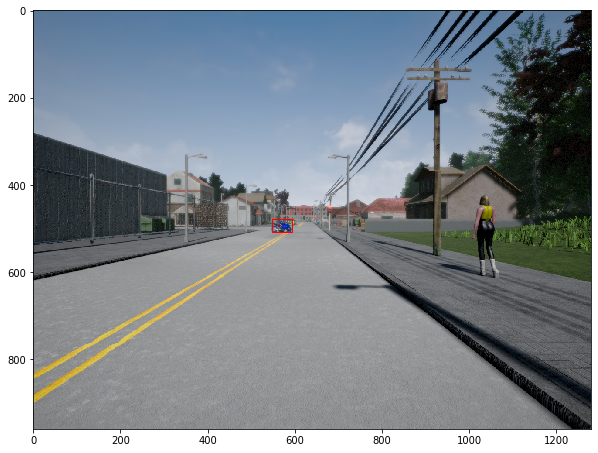

In [14]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Print the depth of the nearest point
print("The Closest Point Depth {0:0.3f}".format(closest_point_depth))

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_left)
ax.add_patch(obstacle_bbox)
plt.show()

## 4. Results


In [15]:
# Part 1. Read Input Data
img_left = files_management.read_left_image()
img_right = files_management.read_right_image()
p_left, p_right = files_management.get_projection_matrices()


# Part 2. Estimating Depth
disp_left = compute_left_disparity_map(img_left, img_right)
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)


# Part 3. Finding the distance to collision
obstacle_image = files_management.get_obstacle_image()
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)


# Print Result Output
print("\n \n Obstacle Location (Left-Top Corner Co-ordinates): {0}".format(obstacle_location))
print("\n\n Closest point depth: {0:0.3f} meters".format(closest_point_depth))

print("\n \n Left Projection Matrix Decomposition:")
print("\n K = \n {0}".format(k_left))
print("\n R = \n {0}".format(r_left))
print("\n t = \n {0}".format(t_left))

print("\n Right Projection Matrix Decomposition:")
print("\n K = \n {0}".format(k_right))
print("\n R = \n {0}".format(r_right))
print("\n t = \n {0}".format(t_right))


 
 Obstacle Location (Left-Top Corner Co-ordinates): (547, 479)


 Closest point depth: 28.927 meters

 
 Left Projection Matrix Decomposition:

 K = 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

 R = 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

 t = 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

 Right Projection Matrix Decomposition:

 K = 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

 R = 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

 t = 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]
